This file loads datasets of real DGA measurements and generates tuning and noise file which can be loaded in the DGA simulator

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import sklearn.neighbors
import scipy.stats
import statsmodels.api as sm
import pickle
import math
import glob
import re

sys.path.insert(0,r'C:\Data\Python\DGA_simulator\simulator')
os.chdir(r'C:\Data\Python\DGA_simulator\simulator')
from pickle_streamer import pickle_streamer
from pls2.pls2_model_set import Measurement
#sys.path.append(r'/home/pdietiker/Dokumente/Python/DGA_simulator/src/GUI')
#sys.path.append(r'/home/pdietiker/Dokumente/Python/DGA_simulator/src')

# Data preparation

load the data set. Each dataset is a 2D array containing the data from several piezo triangle of one channel. 
The piezo triangle has 8322 steps usually

In [3]:
base_path = r"C:\Data\Python\DGA_simulator\Measured_data\20181001 temperature controlled stability"
file_ch1 = r"run_Master__Ch1_20181002_122856_00000.dat"
file_ch2 = file_ch1.replace("CH1","CH2")
#file_ch2=r"Sig_pt3 methane cell_Master_CH2_2018-02-06__16-30-27.dat"
'''
file_ch1=r"C:\Data\Python\DGA_simulator\Measured_data\20181001 temperature controlled stability\overnight_Master__Ch1_20181002_170059_00000.dat"
file_ch2=r"C:\Data\Python\DGA_simulator\Measured_data\20181001 temperature controlled stability\overnight_Master__Ch2_20181002_170059_00000.dat"
'''

'\nfile_ch1=r"C:\\Data\\Python\\DGA_simulator\\Measured_data\x8181001 temperature controlled stability\\overnight_Master__Ch1_20181002_170059_00000.dat"\nfile_ch2=r"C:\\Data\\Python\\DGA_simulator\\Measured_data\x8181001 temperature controlled stability\\overnight_Master__Ch2_20181002_170059_00000.dat"\n'

load and reshape the data

In [4]:
data_ch1_full=np.fromfile(os.path.join(base_path,file_ch1),dtype=np.uint16).reshape((-1,8322))
data_ch2_full=np.fromfile(os.path.join(base_path,file_ch2),dtype=np.uint16).reshape((-1,8322))

Plot the data

<IPython.core.display.Javascript object>


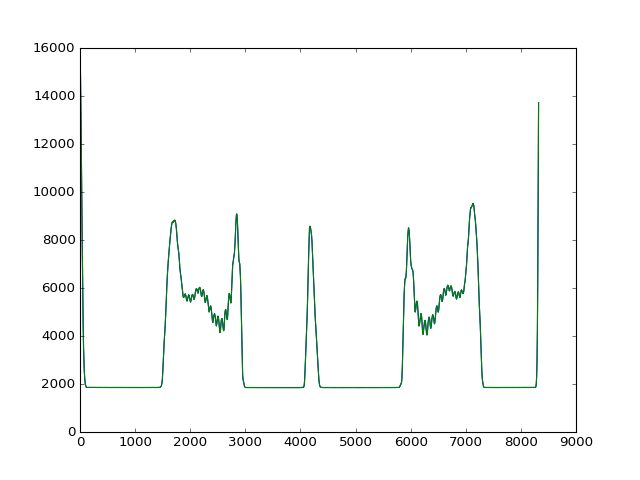

In [5]:
fig, ax=plt.subplots()
#ax.plot(data_ch1_full[0])
#ax.plot(data_ch2_full[0])

ax.plot(np.mean(data_ch1_full,axis=0))
ax.plot(np.mean(data_ch2_full,axis=0))

<IPython.core.display.Javascript object>


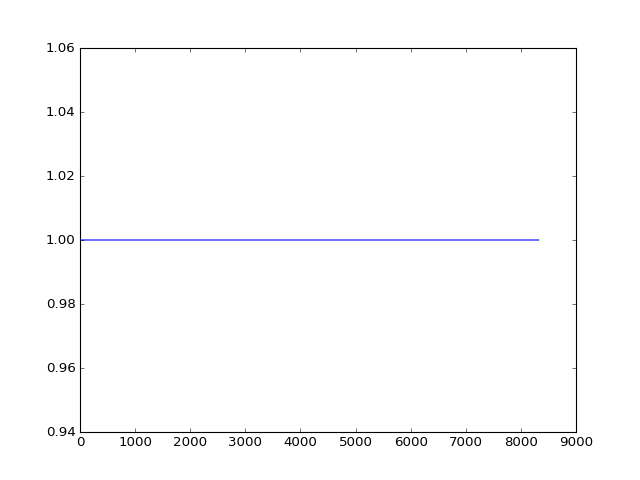

In [6]:
fig, ax=plt.subplots()
ax.plot(data_ch2_full[4]*1.0/data_ch1_full[4])

one has to remove the offset to be able extract the noise correctly. Here we substract the mean value of the detector noise

In [7]:
#remove offset
noise_start=200
noise_stop=1200
data_ch1_full=data_ch1_full.astype(np.float32)
data_ch2_full=data_ch2_full.astype(np.float32)
for ch1,ch2 in zip(data_ch1_full,data_ch2_full):
    ch1-=ch1[noise_start:noise_stop+1].mean()
    ch2-=ch2[noise_start:noise_stop+1].mean()

In [8]:
#check offset correction
data_ch1_full[:,noise_start:noise_stop].mean()

0.0010686289

Here we select the range of datapoint which gets stored. This is usually from the beginning of the lasing range until the upper turning-point of the piezo triangle

In [12]:
#select upwards scan
start=1500
stop=3000
#stop=(np.shape(data_ch1_full)[1])/2+1
data_ch1=data_ch1_full[:,start:stop+1]
data_ch2=data_ch2_full[:,start:stop+1]

The piezo_array contains the piezo voltages corresponding to the selected data points
the wl_array contains the corresponding wavelengths (if known)


In [13]:
#generate piezo and wl array for upward scan
#piezo_array=np.linspace(0.007,62.407,stop)[start:]
piezo_array=np.linspace(0.01,99.98,np.shape(data_ch1_full)[1]/2)[start:stop+1]
wl_array=np.arange(len(piezo_array))
wl_array=np.linspace(3293.04,3393.9,stop-start+1)

In [14]:
wl_array.shape

(1501,)

Plot against wavelength

<IPython.core.display.Javascript object>


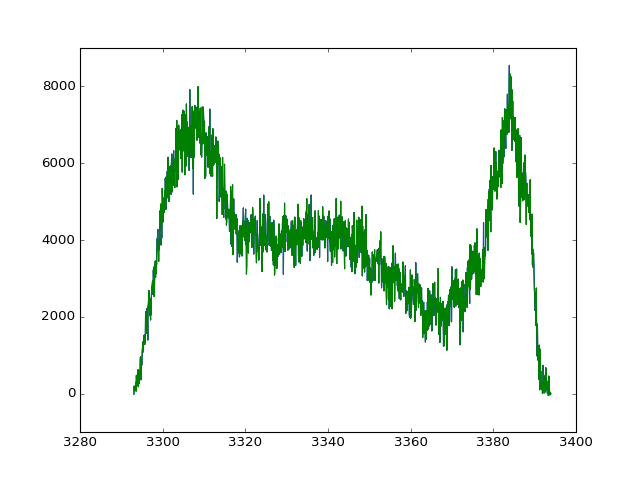

In [15]:
fig, ax=plt.subplots()
ax.plot(wl_array,data_ch1[0])
ax.plot(wl_array,data_ch2[0])

# export data as pickle
we export the selected datapoints as a pickle file

In [44]:
export_file_name = r"0ppmCH4.pck"
export_path=os.path.join(base_path,export_file_name)

In [45]:
#pickler instance 
#delete the file first
try:
    os.remove(export_path)
except WindowsError:
    pass #file not found
pickler=pickle_streamer(export_path)

In [46]:
#save all scans
#data_ch1_norm=data_ch1/data_ch1.mean(axis=0)*data_ch2.mean(axis=0)
for ch1, ch2 in zip(data_ch1,data_ch2):
    pickler.dump(np.vstack((piezo_array,wl_array,ch2,ch1)))

We generate a dataframe with the tuning and the power data and store it in a file ending on "_tuning.pck"

In [47]:
#generate tuning file
#use standard wavelength range
if wl_array.min()==0:
    wl_array=np.linspace(3000,3500,len(piezo_array))
tuning_df=pd.DataFrame({'piezo':piezo_array,'wavelength':wl_array})
power_df=pd.DataFrame({'wavelength_power':wl_array,'power':data_ch1.mean(axis=0)})
data_frame=pd.concat([tuning_df, power_df], axis=1)
tuning_export_path=os.path.splitext(export_path)[0]+"_tuning.pck"
try:
    os.remove(tuning_export_path)
except WindowsError:
    pass #file not found
data_frame.to_pickle(tuning_export_path)

In [97]:
data_frame

piezo   wavelength        power  wavelength_power
0     56.964062  3293.040000    74.994453       3293.040000
1     56.988094  3293.108195    85.250832       3293.108195
2     57.012125  3293.176389    98.491623       3293.176389
3     57.036156  3293.244584   108.352898       3293.244584
4     57.060187  3293.312779   123.621460       3293.312779
5     57.084219  3293.380974   131.550446       3293.380974
6     57.108250  3293.449168   149.332962       3293.449168
7     57.132281  3293.517363   162.439606       3293.517363
8     57.156312  3293.585558   169.467361       3293.585558
9     57.180344  3293.653753   185.904755       3293.653753
10    57.204375  3293.721947   200.585022       3293.721947
11    57.228406  3293.790142   229.147659       3293.790142
12    57.252437  3293.858337   235.761444       3293.858337
13    57.276469  3293.926531   256.425171       3293.926531
14    57.300500  3293.994726   285.542816       3293.994726
15    57.324531  3294.062921   301.893402       3294.062921
16    57.348562  3294.131116   318.352966       3294.131116
17    57.372594  3294.199310   346.052094       3294.199310
18    57.396625  3294.267505   374.863129       3294.267505
19    57.420656  3294.335700   398.248383       3294.335700
20    57.444688  3294.403895   431.470428       3294.403895
21    57.468719  3294.472089   451.856689       3294.472089
22    57.492750  3294.540284   485.563538       3294.540284
23    57.516781  3294.608479   517.570251       3294.608479
24    57.540813  3294.676673   568.741150       3294.676673
25    57.564844  3294.744868   603.663635       3294.744868
26    57.588875  3294.813063   644.782104       3294.813063
27    57.612906  3294.881258   695.184021       3294.881258
28    57.636938  3294.949452   739.122131       3294.949452
29    57.660969  3295.017647   797.429443       3295.017647
...         ...          ...          ...               ...
1450  91.809375  3391.922353  5605.966309       3391.922353
1451  91.833406  3391.990548  5538.442383       3391.990548
1452  91.857438  3392.058742  5414.403809       3392.058742
1453  91.881469  3392.126937  5370.759277       3392.126937
1454  91.905500  3392.195132  5215.316406       3392.195132
1455  91.929531  3392.263327  5154.102539       3392.263327
1456  91.953563  3392.331521  5090.900879       3392.331521
1457  91.977594  3392.399716  4960.116699       3392.399716
1458  92.001625  3392.467911  4886.129883       3392.467911
1459  92.025656  3392.536105  4772.473145       3392.536105
1460  92.049688  3392.604300  4670.760254       3392.604300
1461  92.073719  3392.672495  4527.134766       3392.672495
1462  92.097750  3392.740690  4433.201660       3392.740690
1463  92.121781  3392.808884  4292.670410       3392.808884
1464  92.145813  3392.877079  4226.503418       3392.877079
1465  92.169844  3392.945274  4099.343262       3392.945274
1466  92.193875  3393.013469  3960.326660       3393.013469
1467  92.217906  3393.081663  3827.651855       3393.081663
1468  92.241938  3393.149858  3698.315918       3393.149858
1469  92.265969  3393.218053  3565.854248       3393.218053
1470  92.290000  3393.286247  3435.418213       3393.286247
1471  92.314031  3393.354442  3270.122803       3393.354442
1472  92.338063  3393.422637  3144.988525       3393.422637
1473  92.362094  3393.490832  3012.152344       3393.490832
1474  92.386125  3393.559026  2839.900879       3393.559026
1475  92.410156  3393.627221  2683.180176       3393.627221
1476  92.434188  3393.695416  2562.981689       3393.695416
1477  92.458219  3393.763611  2420.352783       3393.763611
1478  92.482250  3393.831805  2256.441895       3393.831805
1479  92.506281  3393.900000  2120.149170       3393.900000

[1480 rows x 4 columns]

In [2]:
path =r"C:\Data\Python\DGA_simulator\Measured_data\20180411 onwards methane linearity\20180418 measurement\100ppmCH4.pck"
pickler=pickle_streamer(path)

In [3]:
#test the pickler

pickler.load()


array([[   54.26394231,    54.28790865,    54.311875  , ...,
           90.38122596,    90.40519231,    90.42915865],
       [ 3291.92278276,  3291.99905436,  3292.07530907, ...,
         3397.15598599,  3397.22611069,  3397.29624532],
       [  211.01000977,   331.01000977,   365.01000977, ...,
           95.01000977,   563.01000977,   477.01000977],
       [  259.85522461,   310.85522461,   290.85522461, ...,
          154.85522461,   499.85522461,   456.85522461]])

An animation of all the data in the pickle file

<IPython.core.display.Javascript object>


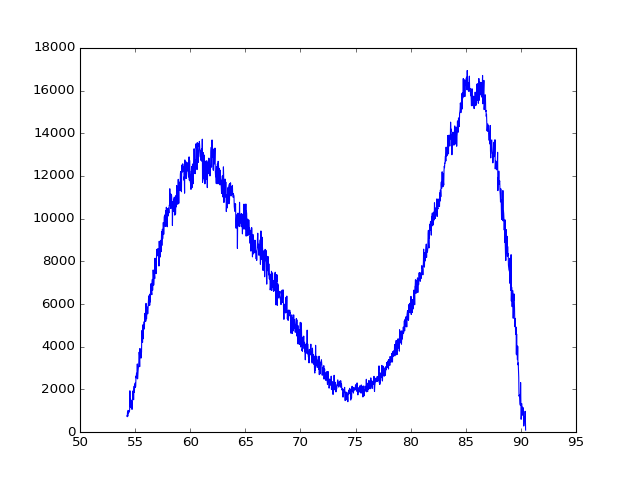

In [4]:
import time
plt.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
from matplotlib.animation import FuncAnimation
fig, ax =plt.subplots()
t = pickler.load()
line,=ax.plot(t[0],t[2])
class Update(object):
    def __init__(self, line,pickler):
        self.line = line
        self.pickler=pickler
        self.stop=False
    def __call__(self, _):
        if not self.stop:
            try:
                t=self.pickler.load()
            except EOFError:
                self.stop=True
            else:
                self.line.set_ydata(t[2])
                self.line.set_xdata(t[0])
        return [self.line]

anim = FuncAnimation(fig, Update(line,pickler), interval=1, blit=True)    
#anim.save(r"C:\Users\CTCHguest\Desktop\test.avi",writer='ffmpeg',dpi=500,bitrate=1000)

In [51]:
#delete the pickler
del pickler

In [36]:
import re

In [145]:
#regex=re.compile(u"^Sig_pt(\d+)\s(\w+)\s(?:pt(\d+)\s([A-Za-z]+)\s*)*(_|cell)")
#regex=re.compile(u"[(?:(\d*pt\d+)\s)|(?:Sig_)]([A-Za-z]+)|(cell)|(repeat)")
regex=re.compile(u"(?:(\d*pt\d+)\s|Sig_)\
                 ([A-Za-z]+)|(?:\s(\d+)(?:\s|_))|(cell)|(repeat)")
name=r"Sig_air 1_Master_CH1_2018-05-09__11-15-29.dat"
#name=r"Sig_1pt5 air pt05 methane cell_Master_CH1_2018-05-04__11-45-48.dat"
match=regex.findall(name)

In [146]:
match

[('', '', '1', '', '')]

In [51]:
match[0][0]==''

True

In [102]:
name=r"Sig_1pt5 air pt05 methane cell_Master_CH1_2018-05-04__11-45-48.dat"
#name=r"Sig_air 1 cell_Master_CH1_2018-05-09__11-15-29.dat"

In [147]:
comp = []
flow = []
cell = False
repeat = False
index = None
file_name=name
#replace dry air by air
file_name = file_name.replace("dry air","air")
print file_name
match=regex.findall(file_name)
#save list of all flows and components set flag if cell is part of file name
if match:
    for f,com,ind,ce,rep  in match:
        if ce=="cell":
            cell=True
        elif rep == "repeat":
            repeat = True
        elif ind!='':
            index=int(ind)
        elif f!='':
            f=f.replace("pt",".")
            flow.append(float(f))
            comp.append(com)
        else:
            flow.append(1.0) #no flow given, only one component present
            comp.append(com)
    conc=np.array(flow)
    conc=100*conc/np.sum(conc)

    name=''
    for c,com in zip(conc,comp):
        if com!="air":
            name+='{:.0f}'.format(c)
            name+="ppm"+com
    if index is not None:
        name+="_{:d}".format(index)
    if repeat:
        name+= "_repeat"
    if cell:
        name+="_cell"
    name+=".pck"
    name=name.replace("methane","CH4")
    if "CH4" not in name:
        #quick fix if methane is not present
        name="0ppmCH4"+name
print name
    

                
    
    

Sig_air 1_Master_CH1_2018-05-09__11-15-29.dat
0ppmCH4_1.pck


In [56]:
float(".3")

0.3

In [37]:
conc

array([ 90.90909091,   9.09090909])

In [29]:
match

[('1pt5', 'air', ''), ('pt05', 'methane', ''), ('', '', 'cell')]

In [49]:
print flow
print comp
print cell


[0.6, 0.05]
['air', 'methane']
True


In [43]:
match.groups()

('6', 'air', '05', 'methane', 'cell')

## Automatic generation of pickle files from file list

In this section we generate a whole bunch of pickle file with a few simple calls. This simplifies the process of generating pickle files

In [64]:
def generate_file_list(base_path, print_names=False):
    '''
    Generates a file list with all the dat files in a directory
    :param base_bath: path to the files
    :type base_path: str
    :param print_names : all names of the channel 1 files are printed of true
    :type print_names : bool
    '''
    
    #this is the original code for the usual sig...CH1.. type of file
    #file_list_ch1 = glob.glob(os.path.join(base_path,"sig*CH1*"))
    #code for the files in 20181001 temperature controlled stability
    file_list_ch1 = glob.glob(os.path.join(base_path,"*Ch1*.dat"))
    file_names = [os.path.basename(x) for x in file_list_ch1]
    if print_names == True:
        for name in file_names:
            print name
    file_list_ch2 = [x.replace("CH1","CH2").replace("Ch1","Ch2") for x in file_list_ch1]
    file_list = zip(file_list_ch1, file_list_ch2)
            
            
    return file_list


def auto_generate_pickle_names(base_path,file_list,name_type="short",print_names=False):
    '''
    Generates a list with the names of the pickle files
    :param base_bath: path to the files
    :type base_path: str
    :param name_type : type of the name to be generated:
                        "short" : a short name including component, concentration, cell, repeat
                        "date"  : a name including an index, cell and date
                        "original" : uses the original name
    :param print_names : all names of the channel 1 files are printed of true
    :type print_names : bool
    '''
    
    #regex=re.compile(u"^Sig_pt(\d+)\s(\w+)\s(?:pt(\d+)\s([A-Za-z]+)\s*)*(_|cell)")
    '''
    regex for filenames with concentrations
    
    u"(?:(\d*pt\d+)\s|Sig_)\ #look for flow (eg. 1pt05) or just Sig_ if no flow is declared
    ([A-Za-z]+)|\            #The component name
    (?:\s(\d+)(?:\s|_))|\    #An index of the measurement (for example in dataset "20180509 100ppm methane repeats")
    (cell)|\                 #looks if cell is present
    (repeat)"                #looks if repeat is present (for example in dataset "20180503 onwards methane linearity")

    '''
    if name_type == "date":
        regex = re.compile(u"(?:(?:\d*pt\d+)\s|Sig_)(?:[A-Za-z]+)|(?:\s(\d+)(?:\s|_))(cell|).*CH1_(.*).dat")
        names = []
        for filetuple in in_files:
            cell=False
            index=None
            file_name=os.path.basename(filetuple[0])
            match=regex.findall(file_name)
            if match:
                for idx, ce,da in match:
                    if idx!='':
                        index=int(idx)
                    if ce=="cell":
                        cell=True
                    if da !='':
                        date = da
                name = str(idx)
                if cell:
                    name+="_cell"
                name = name+"_"+date+".pck"
                names.append(name)

                            
    elif name_type == "short":                   
        regex=re.compile(u"(?:(\d*pt\d+)\s|Sig_)([A-Za-z]+)|(?:\s(\d+)(?:\s|_))|(cell)|(repeat)")
        #the next one is for the "20180621 QCL on off" data
        #regex=re.compile(u"(?:(\d*pt\d+)\s|Sig_)([A-Za-z]+\s*[A-Za-z]*)+(?:\s*(\d*)(?:\s|_))|(cell)|(repeat)")
        names = []
        for filetuple in file_list:
            comp = []
            flow = []
            cell = False
            repeat = False
            index = None
            file_name=os.path.basename(filetuple[0])
            #replace dry air by air
            file_name = file_name.replace("dry air","air")
            match=regex.findall(file_name)
            #save list of all flows and components set flag if cell is part of file name
            if match:
                for f,com,ind,ce,rep  in match:
                    if ce=="cell":
                        cell=True
                    elif rep == "repeat":
                        repeat = True
                    elif ind!='':
                        index=int(ind)
                    elif f!='':
                        f=f.replace("pt",".")
                        flow.append(float(f))
                        comp.append(com)
                    else:
                        flow.append(1.0) #no flow given, only one component present
                        comp.append(com)
                conc=np.array(flow)
                conc=100*conc/np.sum(conc)

                name=''
                for c,com in zip(conc,comp):
                    if com!="air":
                        name+='{:.0f}'.format(c)
                        name+="ppm"+com
                if index is not None:
                    name+="_{:d}".format(index)
                if repeat:
                    name+= "_repeat"
                if cell:
                    name+="_cell"
                name+=".pck"
                name=name.replace("methane","CH4")
                if "CH4" not in name:
                    #quick fix if methane is not present
                    name="0ppmCH4"+name
                names.append(name)
    elif name_type == "original":
        names = []
        for filetuple in in_files:
            cell=False
            index=None
            file_name=os.path.splitext(os.path.basename(filetuple[0]))[0]
            names.append(file_name+".pck")
        
    if print_names:
        for name in names:
            print name
    file_paths = [os.path.join(base_path,name) for name in names]
    return file_paths
        
        
        

def generate_pickle_names(conc_list,component,base_path = None, cell= True, print_names=False):
    '''
    Generates a list of the pickle file names from the given concentrations and component name
    It is best to check the order of the concentraitons from the output of generate_file_list(..., print_names=True)
    :param conc_list : list of the concentrations
    :type conc_list : list
    :param component : name of the component
    :type : str
    :param base_path : path where the pickle files should be saved
    :type base_path : str
    :param cell : wether file with reference cell should be included
    :type cell : bool
    :param print_names : All file names are printed if true
    :type print_names : bool
    
    '''
    names = [str(conc)+"ppm"+component for conc in conc_list]
    if cell == True:
        names_cell = [str(conc)+"ppm"+component+"_cell" for conc in conc_list]
        #flattens the zip
        names = [x for t in zip(names_cell, names) for x in t]
    if print_names == True:
        for name in names:
            print name
    if base_path is not None:
        names = [os.path.join(base_path,x+".pck") for x in names]
    return names


def auto_pickler(file_list,pickle_file_names, noise_range, signal_range,piezo_range,wl_range):
    '''
    genereates a pickle file for every measurement file in file_list
    :param file_List: list of measurement files. Each list element is a tuple two file (one for each channel)
    :type file_list: list of tuples
    :param pickle_file_name: list of the names for the pickle files
    :type list of strings
    :param noise_range: start and stop index of datapoint from which the noise is extracted
    :type noise_range: list with two elements
    :param signal_range: start and stop index of datapoints used as signal
    :type signal_range_ list with two elements
    :param wl_range : either start and stop wavelength or a path to a PLS2 save file from which the wavelengths are extracted
    :type wl_range : list with two elements or string
    '''
    
    #full_scan_length
    scan_length= 8322
    
    #generate wavelength array
    if isinstance(wl_range,str):
        #disable printing
        stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        data = Measurement.load_new_save_file(wl_range)
        #enable printing
        sys.stdout = stdout
        wl_array = data[0]["wavelength"]*1000
        print wl_array.shape
    else:
        wl_array = np.linspace(wl_range[0],wl_range[1],scan_length/2)[signal_range[0]:signal_range[1]+1]
    #generate piezo array
    piezo_array = np.linspace(piezo_range[0],piezo_range[1],scan_length/2)[signal_range[0]:signal_range[1]+1]
    print piezo_array.shape
    
    #generate data frame for tuning file
    tuning_df=pd.DataFrame({'piezo':piezo_array,'wavelength':wl_array})
    power_df=pd.DataFrame({'wavelength_power':wl_array,'power':np.zeros_like(wl_array)})
    data_frame=pd.concat([tuning_df, power_df], axis=1)
    
    for in_file, out_file in zip(file_list,pickle_file_names):
        #load data
        print "in file: "+in_file[0]
        print "out file: "+out_file
        data_ch1_full=np.fromfile(in_file[0],dtype=np.uint16).reshape((-1,scan_length))
        data_ch2_full=np.fromfile(in_file[1],dtype=np.uint16).reshape((-1,scan_length))
        #data_ch1_full=data_ch1_full.astype(np.float32)
        #data_ch2_full=data_ch2_full.astype(np.float32)
        #remove baseline
        #data_ch1_full-=np.mean(data_ch1_full[:,noise_range[0]:noise_range[1]+1],axis=1)[:,np.newaxis]
        #data_ch2_full-=np.mean(data_ch2_full[:,noise_range[0]:noise_range[1]+1],axis=1)[:,np.newaxis]
        
        #for ch1,ch2 in zip(data_ch1_full,data_ch2_full):
        #    ch1-=ch1[noise_range[0]:noise_range[1]+1].mean()
        #    ch2-=ch2[noise_range[0]:noise_range[1]+1].mean()
        #select signal range  
        data_ch1=data_ch1_full[:,signal_range[0]:signal_range[1]+1].astype(np.float32)
        data_ch2=data_ch2_full[:,signal_range[0]:signal_range[1]+1].astype(np.float32)
        
        #save as pickle
        try:
            os.remove(out_file)
        except WindowsError:
            pass #file not found
        pickler=pickle_streamer(out_file)
        for ch1, ch2 in zip(data_ch1,data_ch2):
            pickler.dump(np.vstack((piezo_array,wl_array,ch1,ch2)))
        del pickler
        
        #save tuning file
        data_frame["power"] = data_ch1.mean(axis=0)
        tuning_out_file=os.path.splitext(out_file)[0]+"_tuning.pck"
        try:
            os.remove(tuning_out_file)
        except WindowsError:
            pass #file not found
        data_frame.to_pickle(tuning_out_file)
    
    
    
    

In [65]:
sys.stdout

generate files list from path, the names can be printed with print_names=True

In [66]:
base_path = r"C:\Data\Python\DGA_simulator\Measured_data\20181001 temperature controlled stability"
in_files = generate_file_list(base_path, print_names=True)

overnight_Master__Ch1_20181002_170059_00000.dat
overnight_Master__Ch1_20181002_170059_00001.dat
overnight_Master__Ch1_20181002_170059_00002.dat
overnight_Master__Ch1_20181002_170059_00003.dat
overnight_Master__Ch1_20181002_170059_00004.dat
run_Master__Ch1_20181002_122856_00000.dat
run_Master__Ch1_20181002_122856_00001.dat
run_Master__Ch1_20181002_122856_00002.dat
run_Master__Ch1_20181002_122856_00003.dat
run_Master__Ch1_20181002_122856_00004.dat


list of the concentrations. The order of the list might be wrong and must be corrected

In [69]:
pickle_name_list = auto_generate_pickle_names(os.path.join(base_path),in_files,name_type="original",print_names=True)
#for calibration dataset
#a = pickle_name_list.pop(6)
#b = pickle_name_list.pop(9)
#pickle_name_list.insert(6,b)
#pickle_name_list.insert(7,a)
#for 20180216 and 20180214 dataset
#a = pickle_name_list.pop(8)
#b = pickle_name_list.pop(8)
#pickle_name_list.insert(2,a)
#pickle_name_list.insert(5,b)
#for 20180209 dataset
#
#a = pickle_name_list.pop(8)
#pickle_name_list.insert(6,a)
#for x in pickle_name_list:
#    print os.path.basename(x)


overnight_Master__Ch1_20181002_170059_00000.pck
overnight_Master__Ch1_20181002_170059_00001.pck
overnight_Master__Ch1_20181002_170059_00002.pck
overnight_Master__Ch1_20181002_170059_00003.pck
overnight_Master__Ch1_20181002_170059_00004.pck
run_Master__Ch1_20181002_122856_00000.pck
run_Master__Ch1_20181002_122856_00001.pck
run_Master__Ch1_20181002_122856_00002.pck
run_Master__Ch1_20181002_122856_00003.pck
run_Master__Ch1_20181002_122856_00004.pck


generate the pickle files <br>
parameters: <br>
list of input file  paths <br>
list of output file paths <br>
noise start, stop <br>
signal start, stop <br>
piezo tuning start, stop (for whole data range) <br>
wavelength start, stop or path to binary file from PLS2

In [70]:
wl_path = r"C:/Data/Python/DGA_simulator/Measured_data/20180503 onwards methane linearity/20180503 calibration/0ppmCH4.bin"
#auto_pickler(in_files,pickle_name_list,[1200,1800],[2150,3600],[0.1,99.8],wl_path)#[3200,3400])
#auto_pickler(in_files,pickle_name_list,[1200,1800],[2150,3600],[0.1,99.8],[3200,3400])#wl_path)#)
#next one is for "20180621 QCL on off" data
#auto_pickler(in_files,pickle_name_list,[800,1800],[1920,3450],[0.1,99.8],[3200,3400])#wl_path)
#next is for 20180704 fringes air methane
#auto_pickler(in_files,pickle_name_list,[700,1700],[1990,3400],[0.1,99.8],[3200,3400])#wl_path)
#next is for 20181001 temperature controlled stability
auto_pickler(in_files,pickle_name_list,[200,1200],[1500,3000],[0.1,99.8],[3200,3400])#wl_path)

(1501,)
in file: C:\Data\Python\DGA_simulator\Measured_data\20181001 temperature controlled stability\overnight_Master__Ch1_20181002_170059_00000.dat
out file: C:\Data\Python\DGA_simulator\Measured_data\20181001 temperature controlled stability\overnight_Master__Ch1_20181002_170059_00000.pck
in file: C:\Data\Python\DGA_simulator\Measured_data\20181001 temperature controlled stability\overnight_Master__Ch1_20181002_170059_00001.dat
out file: C:\Data\Python\DGA_simulator\Measured_data\20181001 temperature controlled stability\overnight_Master__Ch1_20181002_170059_00001.pck
in file: C:\Data\Python\DGA_simulator\Measured_data\20181001 temperature controlled stability\overnight_Master__Ch1_20181002_170059_00002.dat
out file: C:\Data\Python\DGA_simulator\Measured_data\20181001 temperature controlled stability\overnight_Master__Ch1_20181002_170059_00002.pck
in file: C:\Data\Python\DGA_simulator\Measured_data\20181001 temperature controlled stability\overnight_Master__Ch1_20181002_170059_00003

## generate the noise files

The covaraince matrix of the detector noise is calculated. 

In [9]:
#covariance matrix of the electronics noise
print noise_start
print noise_stop
a=np.vstack((data_ch1_full[:,noise_start:noise_stop].ravel(),data_ch2_full[:,noise_start:noise_stop].ravel()))
cov_detector=np.cov(a)
cov_detector

400
1400


array([[ 6187.5232875 ,   103.84291764],
       [  103.84291764,  4379.67919149]])

in the next step the noise is split in chunks allong the scan axis. it is assumed that the noise within each chunk of say 100 datapoints is homoskedastic. This makes analysis and simulation of noise much easier. For each chunk the data of say 100 scan is accumulated in the noise_array


In [10]:
#store the noise for each chunk in the array noise
def get_noise(data,chunk_size=100,nr_scans=500,normalised=True,substract_mean=True):
    nr_chunks=int(math.ceil(data.shape[1]*1.0/chunk_size))
    noise_array=np.empty((nr_chunks,nr_scans*chunk_size))
    for idx, ch1 in enumerate(data[:nr_scans]):
        chunk_start=0
        chunk_stop=chunk_start+chunk_size
        for chunk in range(nr_chunks):
            if chunk==nr_chunks-1:
                #last bit of data
                data=ch1[chunk_start:-1]
            else:
                data=ch1[chunk_start:chunk_stop]
            chunk_start+=chunk_size
            chunk_stop+=chunk_size
            chunk_mean=data.mean()
            if substract_mean:
                chunk_noise=(data-chunk_mean)
            else:
                chunk_noise=data
            if normalised:
                chunk_noise/=chunk_mean
            if chunk==nr_chunks-1:
                #last chunk is most probably smaller, repeat chunk_noise to fill the array
                chunk_noise=np.tile(chunk_noise,chunk_size/chunk_noise.shape[0])
                chunk_noise=np.hstack((chunk_noise,chunk_noise[0:chunk_size-chunk_noise.shape[0]]))
            noise_array[chunk,chunk_size*idx:chunk_size*(idx+1)]=chunk_noise
            #noise_array[chunk,chunk_size*idx:chunk_size*(idx+1)]=np.random.normal(0,0.01,chunk_size)
    return noise_array

In [11]:
#calculates the median of a channel for each chunk
def get_median_of_chunk(data,chunk_size=50,nr_scans=500):
    nr_chunks=int(math.ceil(data.shape[1]*1.0/chunk_size))
    mean_array=np.empty((nr_chunks))
    chunk_start=0
    chunk_stop=chunk_start+chunk_size
    for chunk in range(nr_chunks):
        if chunk==nr_chunks-1:
            #last bit of data
            chunk_data=data[:nr_scans,chunk_start:-1]
        else:
            chunk_data=data[:nr_scans,chunk_start:chunk_stop]
        mean_array[chunk]=np.median(chunk_data.ravel())
        chunk_start+=chunk_size
        chunk_stop+=chunk_size
    return mean_array

In [12]:
#generate noise array for channel 1 and channel 2
chunk_size=50
data=(data_ch2-np.median(data_ch2,axis=0))
noise_array_ch2=get_noise(data,chunk_size,normalised=False,substract_mean=False)
mean_array_ch2=get_median_of_chunk(data_ch2,chunk_size)

data=(data_ch1-np.median(data_ch1,axis=0))
noise_array_ch1=get_noise(data,chunk_size,normalised=False,substract_mean=False)
mean_array_ch1=get_median_of_chunk(data_ch1,chunk_size)

We remove the variance induced by the detector from the data. 
This is feasible if the detector noise is normally distributed. The qq-plot shows this is true. 


<IPython.core.display.Javascript object>


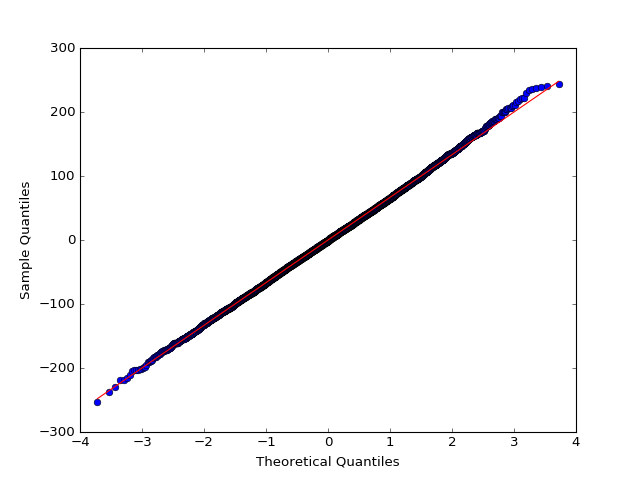

In [13]:
#check if electronics noise is normaly distributed
#Yes it is!
fig,ax=plt.subplots()
a=sm.qqplot(data_ch2_full[0:10,noise_start:noise_stop].ravel(), line='s',ax=ax)

The covariance before removal is:

In [14]:
cor_1=np.cov(np.vstack((noise_array_ch1[0],noise_array_ch2[0])))
cor_2=np.cov(np.vstack((noise_array_ch1[-1],noise_array_ch2[-1])))
print cor_1
print cor_2

[[ 8437.03693269  3271.40377601]
 [ 3271.40377601  8925.66890295]]
[[  51167.95467876   70674.68008829]
 [  70674.68008829  121688.01833209]]


for removing the detector noise we have to uncorrelate signal in advance. This is done for every chunk of data with a cholesky decomposition. After removing the variance of the detector the noise is transformed back by an inverse cholesky transformation.

In [15]:
#uncorrelate each chunk by cholesky decomposition

for i in range(noise_array_ch1.shape[0]):
    #generate array
    signal=np.vstack((noise_array_ch1[i],noise_array_ch2[i]))
    #calculate covariance matrix
    cov=np.cov(signal)
    #calculate cholesky decomposition
    chol=np.linalg.cholesky(cov)
    #uncorrelate signal
    signal_uncorr=np.dot(np.linalg.inv(chol),signal)
    #remove varaince of electronics noise from covaraine matrix
    cov_new=cov-cov_detector
    #calculate new cholesky decomposition
    chol_new=np.linalg.cholesky(cov_new)
    #correlate signal
    signal_new=np.dot(chol_new,signal_uncorr)
    #save result
    noise_array_ch1[i]=signal_new[0]
    noise_array_ch2[i]=signal_new[1]

Check if it worked. This should give the same as before:

In [16]:
cor_1_after=np.cov(np.vstack((noise_array_ch1[0],noise_array_ch2[0])))
cor_2_after=np.cov(np.vstack((noise_array_ch1[-1],noise_array_ch2[-1])))
print cor_1+cov_detector
print cor_2+cov_detector

[[ 14624.56022018   3375.24669365]
 [  3375.24669365  13305.34809444]]
[[  57355.47796626   70778.52300592]
 [  70778.52300592  126067.69752357]]


We need the relative noise. So let us divide the noise_array by its mean value

In [17]:
#divide by chunk mean to get relative noise
noise_array_ch1/=mean_array_ch1[:,np.newaxis]
noise_array_ch2/=mean_array_ch2[:,np.newaxis]

An array of the piezo voltages corresponding to each chunk in the noise arrays

In [18]:
#piezo_array for noise
piezo_array_noise=np.linspace(piezo_array.min(),piezo_array.max(),noise_array_ch1.shape[0])

We store all the stuff in a dataframe
this can then be loaded in the DGA simulator

In [28]:
#dataframe of the noise
noise_ch1_df=pd.DataFrame()
for idx, chunck in enumerate(noise_array_ch1):
    noise_ch1_df[piezo_array_noise[idx]]=chunck
noise_ch2_df=pd.DataFrame()
for idx, chunck in enumerate(noise_array_ch2):
    noise_ch2_df[piezo_array_noise[idx]]=chunck

In [55]:
#dict with electonics and detector noise
noise_dict={}
noise_dict["detector_noise_cov"]=cov_detector
#noise_dict["dif_electronics_noise_sd"]=np.sqrt(cov[1,1]-2*cov[1,0])
#set detector noise to zero because electronics noise from file contains detector noise
#noise_dict["detector_noise_sd"]=0

Save data to a file

In [56]:
path=r"C:\Data\Python\DGA_simulator\Measured_data\20171019 noise level estimation\noise_25v_test.pck"
with open(path, 'wb') as handle:
    pickle.dump(noise_ch2_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(noise_ch1_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(noise_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

# gaussian_kde_2D
This is the class we use to simulate noise

it generates a kernel density estimator for every chunk in the noise_array. 
For resampling the piezo voltage is interpolated between the voltages of chunks and samples are then drawn from the two closest kernel density estimators in a ratio corresponding to the "distance" in piezo votage.
Piezo voltages to draw samples at are grouped for performance reasons. 

In [24]:
%load_ext autoreload
%autoreload 2
from gaussian_kde_2D import gaussian_kde_2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Some test cases

In [20]:
def measure(n):
    "Measurement model, return two coupled measurements."
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2
#correlated data
data=measure(1000)
#correlated data from multivariate_normal (sometimes this gives a LinAlgError: error. just try again)
data=scipy.stats.multivariate_normal(mean=[0,0],cov=[[100*sys.float_info.min,0],[0,sys.float_info.min]]).rvs(10000)

n_estimator=gaussian_kde_2D(data[0],[10],data[1],method='scipy',bandwidth=0.1)
#only one channel at two piezo voltages:
n_estimator=gaussian_kde_2D(np.vstack((np.random.normal(0,1,1000),np.random.normal(0,10,1000))),[10,80],method='scikit',bandwidth=0.1)

#with our real data
n_estimator=gaussian_kde_2D(noise_array_ch1,piezo_array_noise,noise_array_ch2,method='scipy',bandwidth=0.1)

In [21]:
#resample data
n_estimator.resample(np.linspace(10,60,20),1,1)

c:\python27\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


array([[  7.43965252e-02,   8.81976726e-02],
       [ -1.65344930e-01,  -1.19970876e-01],
       [  8.46275180e-01,   9.88044318e-01],
       [ -1.49303461e-01,  -1.76233379e-01],
       [ -4.01753531e-01,  -3.84096927e-01],
       [ -3.61228911e-01,  -3.97807359e-01],
       [ -9.34035219e-02,  -6.76060557e-02],
       [  1.90123888e-02,   3.52109424e-02],
       [  4.16226422e-03,   8.51546668e-04],
       [ -9.03463429e-02,  -4.21204049e-02],
       [ -2.63578604e-01,  -2.55908625e-01],
       [  5.94205620e-02,   7.99162905e-03],
       [  7.59517627e-02,   4.23287012e-02],
       [  1.67350673e-02,   4.48259927e-02],
       [  1.17540036e-01,   1.70265370e-01],
       [  3.92623413e-01,   4.07258629e-01],
       [ -4.63343459e-02,  -2.24177571e-02],
       [  1.77467739e-02,   3.31124022e-03],
       [  1.22694026e-02,   4.79185449e-02],
       [ -9.95079966e-02,  -1.06669967e-01]])

In [8]:
#scikit is a bit faster than scipy
n_estimator=gaussian_kde_2D(np.vstack((np.random.normal(0,1,1000),np.random.normal(0,10,1000))),[10,80],method='scipy',bandwidth=0.1)
%timeit n_estimator.resample(np.linspace(10,60,2000),1,1)
n_estimator=gaussian_kde_2D(np.vstack((np.random.normal(0,1,1000),np.random.normal(0,10,1000))),[10,80],method='scikit',bandwidth=0.1)
%timeit n_estimator.resample(np.linspace(10,60,2000),1,1)

100 loops, best of 3: 16.4 ms per loop
100 loops, best of 3: 9.2 ms per loop


Plots of the probability distribution function

<IPython.core.display.Javascript object>


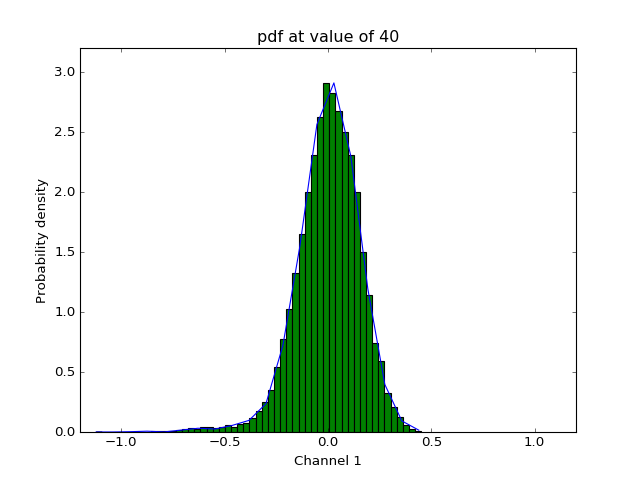

In [76]:
n_estimator.pdf_plot1D(40,axis='1')

<IPython.core.display.Javascript object>


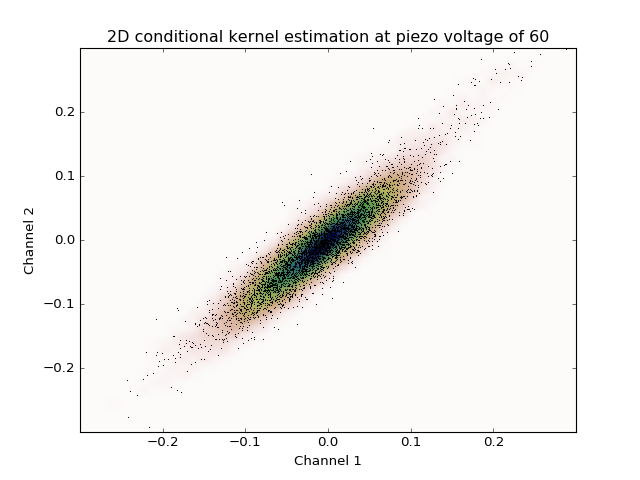

In [22]:
n_estimator.pdf_plot2D(axes=("1","2"),z_value=60)#,ylim=[-0.3,0.3],xlim=[-0.3,0.3],save_path=r"C:\Users\CTCHguest\Desktop\dga\2D_noise_new.jpg")

<IPython.core.display.Javascript object>


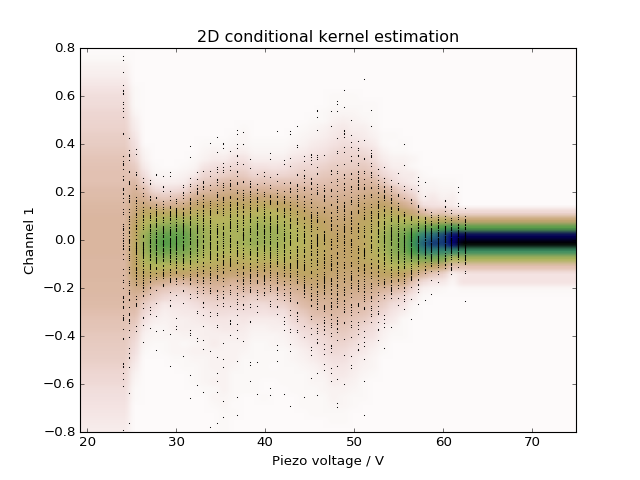

In [23]:
n_estimator.pdf_plot2D(axes=("p","1"))#,ylim=[-0.8,0.8],save_path=r"C:\Users\CTCHguest\Desktop\dga\2D_noise_new2.jpg")

In [206]:
regex = re.compile(r"(.*)\\\d*(ppm.*)")
path=r"skdjfdf\\10ppm_2_sdf.pck"
a=regex.match(path)

In [207]:
a.groups()

('skdjfdf\\', 'ppm_2_sdf.pck')

In [196]:
u"(.*"+os.sep+u")(\d)+ppm_.*"

u'(.*\\)(\\d)+ppm_.*'

In [170]:
r"(.*"+os.sep+r")\d+ppm_.*"

'(.*\\)\\d+ppm_.*'